In [1]:
from __future__ import print_function
import argparse
import pickle

import numpy as np
import torch
from captum.attr import IntegratedGradients

import cbig.osama2024.misc as misc

f:\Professional\Thesis\RNN-AD\RNN_py3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### IG

In [2]:
checkpoint_path = 'output/model.pt'
data_path = 'output/val.pkl'

device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load(checkpoint_path)
model.to(device)

with open(data_path, 'rb') as fhandler:
    data = pickle.load(fhandler)

In [3]:
integrated_gradients = IntegratedGradients(model)

In [4]:
test_data = data['test']
pred_start = data['pred_start']
duration = data['duration']
baseline = data['baseline']

### IG for a specific duration and target class (CN:0, MCI:1, AD:2)

In [ ]:


duration = 20
target_index_2 = 0

model.eval()
ret = {'subjects': test_data.subjects}
ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
ret['dates'] = misc.make_date_col(
    [pred_start[s] for s in test_data.subjects], duration)

col = ['ADAS13', 'Ventricles', 'ICV']
indices = misc.get_index(list(test_data.value_fields()), col)
mean = model.mean[col].values.reshape(1, -1)
stds = model.stds[col].values.reshape(1, -1)

attributions = {}
    
for i in range(len(test_data)):
    data_entry = test_data[i]
    rid = data_entry['rid']
    all_tp = data_entry['tp'].squeeze(axis=1)
    start = misc.month_between(pred_start[rid], baseline[rid])
    assert np.all(all_tp == np.arange(len(all_tp)))
    mask = all_tp < start
    itime = np.arange(start + duration)
    icat = np.asarray(
        [misc.to_categorical(c, 3) for c in data_entry['cat'][mask]])
    ival = data_entry['val'][:, None, :][mask]
    
    in_val = np.full((len(itime), ) + ival.shape[1:], np.nan)
    in_val[:len(ival)] = ival
    
    in_cat = np.full((len(itime), ) + icat.shape[1:], np.nan)
    in_cat[:len(icat)] = icat
    
    input_val = torch.tensor(in_val, dtype=torch.float32).to(device)
    input_cat = torch.tensor(in_cat, dtype=torch.float32).to(device)
    # input_val = in_val
    # input_cat = in_cat
    
    # target = (0,0,0,0)
    # # convert to tensor
    # target_tensor = torch.tensor(target, dtype=torch.float32).to(device)
    
    attr_cat = integrated_gradients.attribute(
        inputs=(input_cat, input_val), 
        baselines=None,  # You can provide baselines if needed
        target=(0,target_index_2)  # You can specify the target output index if needed
    )
    
    # Save attributions
    attributions[rid] = {
        'cat': attr_cat
    }
    
    # ocat, oval = predict_subject(model, icat, ival, itime)


### IG for durations 40,60,80

In [5]:
durations = [20, 40, 60, 80]
feature_indices = [2, 15, 13]

for duration in durations:
    print(f"Duration: {duration}")
    for c in feature_indices:
        print(f"Feature index: {c}")
        target_index_2 = c
        
        model.eval()
        ret = {'subjects': test_data.subjects}
        ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
        ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
        ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
        ret['dates'] = misc.make_date_col(
            [pred_start[s] for s in test_data.subjects], duration)

        col = ['ADAS13', 'Ventricles', 'ICV']
        indices = misc.get_index(list(test_data.value_fields()), col)
        mean = model.mean[col].values.reshape(1, -1)
        stds = model.stds[col].values.reshape(1, -1)
        
        
        attributions = {}
    
        for i in range(len(test_data)):
            data_entry = test_data[i]
            rid = data_entry['rid']
            all_tp = data_entry['tp'].squeeze(axis=1)
            start = misc.month_between(pred_start[rid], baseline[rid])
            assert np.all(all_tp == np.arange(len(all_tp)))
            mask = all_tp < start
            itime = np.arange(start + duration)
            icat = np.asarray(
                [misc.to_categorical(c, 3) for c in data_entry['cat'][mask]])
            ival = data_entry['val'][:, None, :][mask]
            
            in_val = np.full((len(itime), ) + ival.shape[1:], np.nan)
            in_val[:len(ival)] = ival
            
            in_cat = np.full((len(itime), ) + icat.shape[1:], np.nan)
            in_cat[:len(icat)] = icat
            
            input_val = torch.tensor(in_val, dtype=torch.float32).to(device)
            input_cat = torch.tensor(in_cat, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                out_cat = model(input_cat, input_val)
        
            out_cat = out_cat.cpu().numpy()
            ret['DX'].append(out_cat[-duration:, 0, :])
            
            # target = (0,0,0,0)
            # # convert to tensor
            # target_tensor = torch.tensor(target, dtype=torch.float32).to(device)
            
            attr_cat = integrated_gradients.attribute(
                inputs=(input_cat, input_val), 
                baselines=None,  # You can provide baselines if needed
                target=(0,target_index_2)  # You can specify the target output index if needed
            )
            
            # Save attributions
            attributions[rid] = {
                'cat': attr_cat
            }
            
            my_dict = attributions

        #save the attributions
        with open(f'MyData/attr3/attributions_{duration}_{target_index_2}.pickle', 'wb') as pickle_file:
            pickle.dump(my_dict, pickle_file)
        
        #save the ret
        with open(f'MyData/ret3/ret_{duration}_{target_index_2}.pickle', 'wb') as pickle_file:
            pickle.dump(ret, pickle_file)
            
        
        

Duration: 20
Feature index: 2
Feature index: 15
Feature index: 13
Duration: 40
Feature index: 2
Feature index: 15
Feature index: 13
Duration: 60
Feature index: 2
Feature index: 15
Feature index: 13
Duration: 80
Feature index: 2
Feature index: 15
Feature index: 13


### Load attributions

In [5]:
import pickle 

loaded_duration = 80
loaded_target_f_index_2 = 2

# load ret
with open(f'MyData/ret2/ret_{loaded_duration}_{loaded_target_f_index_2}.pickle', 'rb') as pickle_file:
    ret = pickle.load(pickle_file)
    
with open(f'MyData/attr3/attributions_{loaded_duration}_{loaded_target_f_index_2}.pickle', 'rb') as pickle_file:
    my_dict = pickle.load(pickle_file)
    
attributions = my_dict

### Grouping

Here we divide the patients according to their final predicted classes. So there can not be more than 3 divisions. At the same time attributions are divided into 3 groups as well

In [6]:
def divide_data_by_max_probability(ret, attributions, day):
    # Initialize
    divided_ret = {i: [] for i in range(ret['DX'][0].shape[1])}
    divided_attributions = {i: [] for i in range(ret['DX'][0].shape[1])}
    

    for patient_index in range(len(ret['DX'])):
        # Get the diagnosis probabilities for the specified day for the current patient
        probabilities = ret['DX'][patient_index][day - 1]

        # Find the index of the diagnosis class with the maximum probability for this day
        max_index = np.argmax(probabilities)
        
        #print(f'max index is ', max_index)

        # Append the current patient's data to the corresponding divided part for ret
        divided_ret[max_index].append({
            'patient_index': patient_index,
            'diagnosis_probabilities': probabilities
        })

        # Append the corresponding attribution data
        attribution_key = list(attributions.keys())[patient_index]
        divided_attributions[max_index].append({
            'patient_index': patient_index,
            'attribution_data': attributions[attribution_key]
        })

    return divided_ret, divided_attributions

# Example usage
day = loaded_duration
divided_ret, divided_attributions = divide_data_by_max_probability(ret, attributions, day)

# Print the lengths of divided parts for ret
for class_index, data_list in divided_ret.items():
    print(f"Class {class_index}: {len(data_list)} patients")

# Print the lengths of divided parts for attributions
for class_index, data_list in divided_attributions.items():
    print(f"Class {class_index}: {len(data_list)} attributions")


Class 0: 54 patients
Class 1: 36 patients
Class 2: 69 patients
Class 0: 54 attributions
Class 1: 36 attributions
Class 2: 69 attributions


In [ ]:
print(divided_attributions[1][0]['attribution_data']['cat'][1][0])

# convert to numpy
np_attributions = np.array(divided_attributions[1][0]['attribution_data']['cat'][1][0][0])


### Plot attributions
parameters:
* feature_index = which feature to focus on
* num_patient = count of patients. -1 means all from that group
* class_index = select the attribution group. 

saving in MyData/plots/80/target_feature_13/attr_C2_f3.png


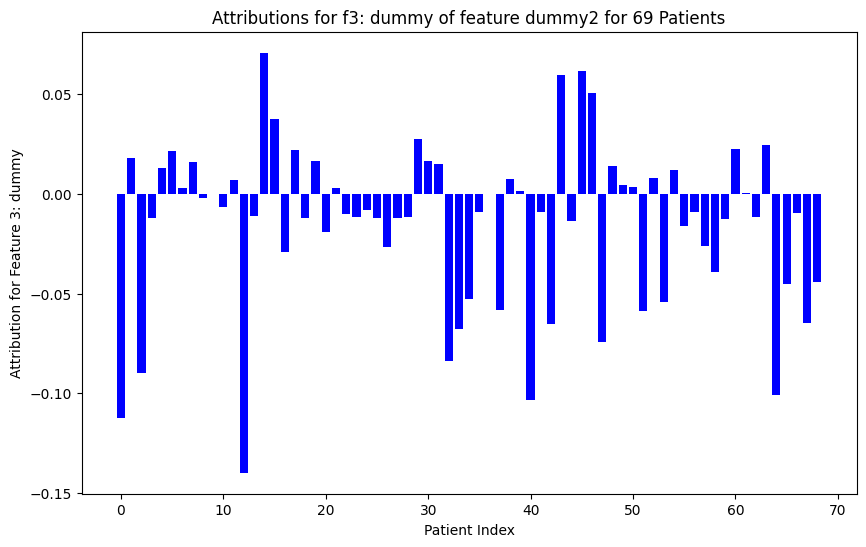

In [7]:
import matplotlib.pyplot as plt

def plot_feature_attributions(feature_index, num_patients, class_index, 
                              divided_attributions, feature_name, target_feature_name='', isShow=True):
    # Extract attributions for the specified class index and feature index
    attributions = divided_attributions[class_index]

    if num_patients == -1:
        num_patients = len(attributions)
        
    # if class_index == 0:
    #     #target_feature_name = 'ADAS13'
    #     loaded_target_f_index_2 = 2
    # elif class_index == 1:
    #     #target_feature_name = 'Ventricles'
    #     loaded_target_f_index_2 = 15
    # else:
    #     #target_feature_name = 'ICV'
    #     loaded_target_f_index_2 = 13
        
    

    # Extract the feature attributions for the specified feature index
    feature_attributions = [attribution['attribution_data']['cat'][1][0][0][feature_index].numpy() for attribution in attributions[:num_patients]]

    feature_mean = np.mean(feature_attributions)
    feature_std = np.std(feature_attributions)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    for i, attribution in enumerate(feature_attributions):
        plt.bar(i, attribution, color='blue')
    plt.xlabel('Patient Index')
    plt.ylabel(f'Attribution for Feature {feature_index}: {feature_name}')
    plt.title(f'Attributions for f{feature_index}: {feature_name} of feature {target_feature_name} for {num_patients} Patients')
    
    if isShow:
        plt.show()
    
    
    print(f"saving in MyData/plots/{loaded_duration}/target_feature_{loaded_target_f_index_2}/attr_C{class_index}_f{feature_index}.png")
    plt.savefig(f'MyData/plots/{loaded_duration}/target_feature_{loaded_target_f_index_2}/attr_C{class_index}_f{feature_index}.png')
    
    return feature_mean, feature_std

# Example usage
feature_index = 3  # Change this to the desired feature index
num_patients = -1  # Change this to -1 to include all patients, otherwise specify a number
class_index = 2  # Change this to the desired class index
loaded_target_f_index_2 = 13
feature_mean, feature_std = \
    plot_feature_attributions(feature_index, num_patients, \
        class_index, divided_attributions, "dummy", "dummy2", False)


### Combined attempt

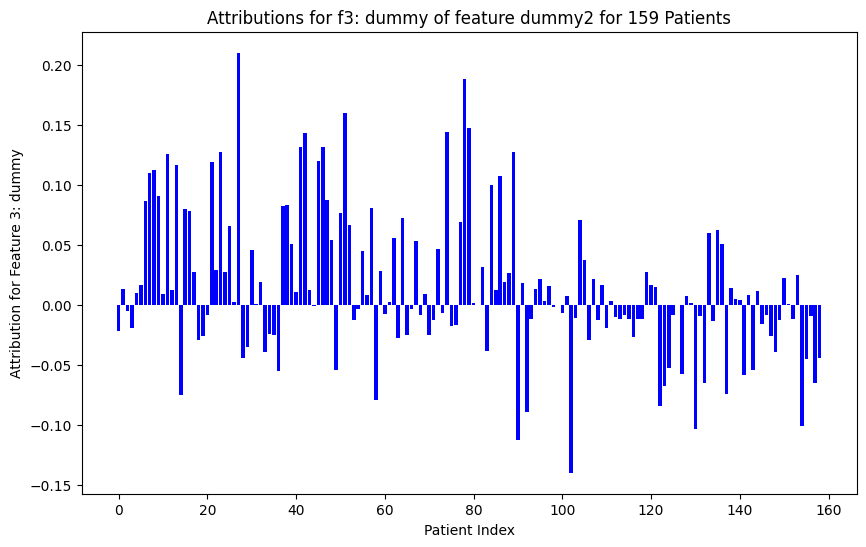

In [8]:
import matplotlib.pyplot as plt

def plot_feature_attributions2(feature_index, num_patients, class_index, 
                               attributions, feature_name, target_feature_name='', isShow=True):
    # Extract attributions for the specified class index and feature index
    attributions0 = divided_attributions[0]
    attributions1 = divided_attributions[1]
    attributions2 = divided_attributions[2]
    
    #concat 3 lists
    attributions = attributions0 + attributions1 + attributions2

    if num_patients == -1:
        num_patients = len(attributions)
    #target_feature_name = ''
    # if class_index == 0:
    #     #target_feature_name = 'ADAS13'
    #     loaded_target_f_index_2 = 2
    # elif class_index == 1:
    #     #target_feature_name = 'Ventricles'
    #     loaded_target_f_index_2 = 15
    # else:
    #     #target_feature_name = 'ICV'
    #     loaded_target_f_index_2 = 13
        

    # Extract the feature attributions for the specified feature index
    feature_attributions = [attribution['attribution_data']['cat'][1][0][0][feature_index].numpy() for attribution in attributions[:num_patients]]

    feature_mean = np.mean(feature_attributions)
    feature_std = np.std(feature_attributions)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    for i, attribution in enumerate(feature_attributions):
        plt.bar(i, attribution, color='blue')
    plt.xlabel('Patient Index')
    plt.ylabel(f'Attribution for Feature {feature_index}: {feature_name}')
    plt.title(f'Attributions for f{feature_index}: {feature_name} of feature {target_feature_name} for {num_patients} Patients')
    
    if isShow:
        plt.show()
        
    #save fig
    plt.savefig(f'MyData/plots/{loaded_duration}/target_feature_{loaded_target_f_index_2}/attr_all_f{feature_index}.png')
    
    return feature_mean, feature_std

# Example usage
feature_index = 3  # Change this to the desired feature index
num_patients = -1  # Change this to -1 to include all patients, otherwise specify a number
class_index = 2  # Change this to the desired class index

feature_mean, feature_std = \
    plot_feature_attributions2(feature_index, num_patients, \
        class_index, divided_attributions, "dummy", "dummy2", False)

### detailed analysis

In [ ]:
#durations = [20, 40, 60, 80]
durations = [20, 40, 60, 80]
categories = [0, 1, 2]
#categories = [1]
feature_indices = [2, 15, 13]

for duration in durations:
    loaded_duration = duration
    for c in categories:
        print(f"Duration: {duration}")
        print(f"Feature Index: {c}")
        target_index_2 = feature_indices[c]
        loaded_target_f_index_2 = target_index_2
        
        target_feature_name = ''
        if c == 0:
            target_feature_name = 'ADAS13'
        elif c == 1:
            target_feature_name = 'Ventricles'
        else:
            target_feature_name = 'ICV'
        
        #load attributions
        with open(f'MyData/attr3/attributions_{duration}_{target_index_2}.pickle', 'rb') as pickle_file:
            my_dict = pickle.load(pickle_file)
        
        #load ret
        with open(f'MyData/ret2/ret_{duration}_{c}.pickle', 'rb') as pickle_file:
            ret = pickle.load(pickle_file)
            
        #divide data
        divided_ret, divided_attributions = divide_data_by_max_probability(ret, my_dict, duration)
        
        for class_index, data_list in divided_ret.items():
            print(f"Class {class_index}: {len(data_list)} patients")
            
        for class_index, data_list in divided_attributions.items():
            print(f"Class {class_index}: {len(data_list)} attributions")
            
        mean_values_CN = []
        mean_values_MCI = []    
        mean_values_AD = []

        mean_values_all = []

        std_values_CN = []
        std_values_MCI = []
        std_values_AD = []

        std_values_all = []

        num_features = 22
        num_patients = -1
        
        #list the feature names, means and stds
        feature_names = misc.load_feature('data/features')

        for i in range(0, num_features):
            feature_mean, feature_std = \
                plot_feature_attributions(i, num_patients, \
                    0, divided_attributions, feature_names[i], target_feature_name, False)
            mean_values_CN.append(feature_mean)
            std_values_CN.append(feature_std)
            
            feature_mean, feature_std = \
                plot_feature_attributions(i, num_patients, \
                    1, divided_attributions, feature_names[i], target_feature_name, False)
            mean_values_MCI.append(feature_mean)
            std_values_MCI.append(feature_std)
            
            feature_mean, feature_std = \
                plot_feature_attributions(i, num_patients, \
                    2, divided_attributions, feature_names[i], target_feature_name, False)
            mean_values_AD.append(feature_mean)
            std_values_AD.append(feature_std)
            
            feature_mean, feature_std = \
                plot_feature_attributions2(i, num_patients, \
                    0, divided_attributions, feature_names[i], target_feature_name, False)
            mean_values_all.append(feature_mean)
            std_values_all.append(feature_std)
            
        
        # save the feature names, means and stds as a csv
        # import csv

        with open(f'MyData/plots/{loaded_duration}/target_feature_{loaded_target_f_index_2}/feature_attributions.csv', mode='w') as file:
            writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['Feature Name', 'CN Mean', 'CN Std', 
                            'MCI Mean', 'MCI Std', 'AD Mean', 'AD Std', 'Combined Mean', 'Combined Std'])
            for i in range(0, num_features):
                writer.writerow([feature_names[i], mean_values_CN[i], std_values_CN[i], 
                                mean_values_MCI[i], std_values_MCI[i], mean_values_AD[i], 
                                std_values_AD[i], mean_values_all[i], std_values_all[i]])
                    

In [19]:
#list the feature names, means and stds
feature_names = misc.load_feature('data/features')
len(feature_names)

22

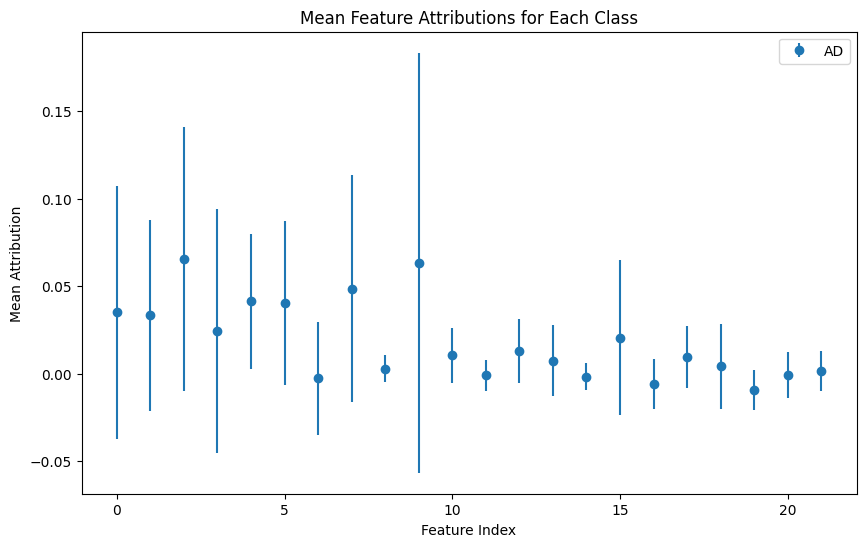

In [120]:
#plot the mean values
import matplotlib.pyplot as plt
import numpy as np

# data
x = np.arange(22)
y1 = mean_values_CN
y2 = mean_values_MCI
y3 = mean_values_AD

y4 = mean_values_all

std1 = std_values_CN
std2 = std_values_MCI
std3 = std_values_AD

std4 = std_values_all

# plot with error bars
plt.figure(figsize=(10, 6))

#plt.errorbar(x, y2, yerr=std2, fmt='o', label='MCI')
#plt.errorbar(x, y1, yerr=std1, fmt='o', label='CN')
plt.errorbar(x, y3, yerr=std3, fmt='o', label='AD')
#plt.errorbar(x, y4, yerr=std4, fmt='o', label='All')
plt.xlabel('Feature Index')
plt.ylabel('Mean Attribution')
plt.title('Mean Feature Attributions for Each Class')
plt.legend()
plt.show()


### saving the mean and std values in csv

In [121]:
#list the feature names, means and stds
feature_names = misc.load_features('data/features')

# save the feature names, means and stds as a csv
import csv

# create the csv if doesnt exits
# import os
# if not os.path.exists(f'MyData/plots/{loaded_duration}/target_{loaded_target_index_2}/feature_attributions.csv'):
#     print("nai")
#     os.makedirs(f'MyData/plots/{loaded_duration}/target_{loaded_target_index_2}/feature_attributions.csv')

with open(f'MyData/plots/{loaded_duration}/target_{loaded_target_f_index_2}/feature_attributions.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Feature Name', 'CN Mean', 'CN Std', 
                     'MCI Mean', 'MCI Std', 'AD Mean', 'AD Std', 'Combined Mean', 'Combined Std'])
    for i in range(0, num_features):
        writer.writerow([feature_names[i], mean_values_CN[i], std_values_CN[i], 
                         mean_values_MCI[i], std_values_MCI[i], mean_values_AD[i], 
                         std_values_AD[i], mean_values_all[i], std_values_all[i]])
        

In [22]:
#load the csv
import pandas as pd

loaded_csv_duration = 80
loaded_csv_target_index_2 = 13


df = pd.read_csv(f'MyData/plots/{loaded_csv_duration}/target_feature_{loaded_csv_target_index_2}/feature_attributions.csv')
df.head()


# list the top 5 and bottom 5 features for each class only two related columns feature name and related mean
top_5_CN = df.nlargest(5, 'CN Mean')[['Feature Name', 'CN Mean']]
bottom_5_CN = df.nsmallest(5, 'CN Mean')[['Feature Name', 'CN Mean']]

top_5_MCI = df.nlargest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]
bottom_5_MCI = df.nsmallest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]

top_5_AD = df.nlargest(5, 'AD Mean')[['Feature Name', 'AD Mean']]
bottom_5_AD = df.nsmallest(5, 'AD Mean')[['Feature Name', 'AD Mean']]

top_5_all = df.nlargest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]
bottom_5_all = df.nsmallest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]


bottom_5_all


,Feature Name,Combined Mean
3,MMSE,-0.020180
18,FDG,-0.018478
16,WholeBrain,-0.012183
0,CDRSB,-0.009346
7,RAVLT_perc_forgetting,-0.008986


In [23]:

top_5_all

,Feature Name,Combined Mean
13,ICV,0.083831
20,TAU_UPENNBIOMK9_04_19_17,0.010949
11,Fusiform,0.010096
5,RAVLT_learning,0.008548
10,Entorhinal,0.008489


In [57]:
# print the feature and only their means for each class in a text file
with open(f'MyData/plots/{loaded_csv_duration}/target_feature_{loaded_csv_target_index_2}/top_bottom_features.txt', 'w') as f:
    f.write("Top 5 CN Features\n")
    f.write(top_5_CN.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 CN Features\n")
    f.write(bottom_5_CN.to_string())
    f.write("\n\n")
    
    f.write("Top 5 MCI Features\n")
    f.write(top_5_MCI.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 MCI Features\n")
    f.write(bottom_5_MCI.to_string())
    f.write("\n\n")
    
    f.write("Top 5 AD Features\n")
    f.write(top_5_AD.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 AD Features\n")
    f.write(bottom_5_AD.to_string())
    f.write("\n\n")
    
    f.write("Top 5 All Features\n")
    f.write(top_5_all.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 All Features\n")
    f.write(bottom_5_all.to_string())
    f.write("\n\n")


In [116]:
import matplotlib.pyplot as plt

# horizontal subplots
def plot_features_all_durations(target_class, topORbot):
    #load csv
    df1 = pd.read_csv(f'MyData/plots/20/target_{target_class}/feature_attributions.csv')
    df2 = pd.read_csv(f'MyData/plots/40/target_{target_class}/feature_attributions.csv')
    df3 = pd.read_csv(f'MyData/plots/60/target_{target_class}/feature_attributions.csv')
    df4 = pd.read_csv(f'MyData/plots/80/target_{target_class}/feature_attributions.csv')
    
    if target_class == 0:
        target_class_name = 'CN'
    elif target_class == 1:
        target_class_name = 'MCI'
    else:
        target_class_name = 'AD'
    
    # data
    top_5_1 = df1.nlargest(5, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']] 
    top_5_2 = df2.nlargest(5, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    top_5_3 = df3.nlargest(5, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    top_5_4 = df4.nlargest(5, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    
    bottom_5_1 = df1.nsmallest(5, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    bottom_5_2 = df2.nsmallest(5, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    bottom_5_3 = df3.nsmallest(5, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    bottom_5_4 = df4.nsmallest(5, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    
    # plot with error bars
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
        
    top_5_1_sorted = top_5_1.sort_values(by=f'{target_class_name} Mean', ascending=True)
    bottom_5_1_sorted = bottom_5_1.sort_values(by=f'{target_class_name} Mean', ascending=False)
    top_5_2_sorted = top_5_2.sort_values(by=f'{target_class_name} Mean', ascending=True)
    bottom_5_2_sorted = bottom_5_2.sort_values(by=f'{target_class_name} Mean', ascending=False)
    top_5_3_sorted = top_5_3.sort_values(by=f'{target_class_name} Mean', ascending=True)
    bottom_5_3_sorted = bottom_5_3.sort_values(by=f'{target_class_name} Mean', ascending=False)
    top_5_4_sorted = top_5_4.sort_values(by=f'{target_class_name} Mean', ascending=True)
    bottom_5_4_sorted = bottom_5_4.sort_values(by=f'{target_class_name} Mean', ascending=False)
    
    
    if topORbot == 'top':
        axs[0, 0].barh(top_5_1_sorted['Feature Name'], top_5_1_sorted[f'{target_class_name} Mean'], color='blue')
        axs[0, 0].set_title('Top 5 Positively Attributed Features - 20 Days')
        axs[0, 0].set_xlabel('Mean Attribution')
        #axs[0, 0].set_ylabel('Feature Name')
        
        axs[0, 1].barh(top_5_2_sorted['Feature Name'], top_5_2_sorted[f'{target_class_name} Mean'], color='blue')
        axs[0, 1].set_title('Top 5 Positively Attributed Features - 40 Days')
        axs[0, 1].set_xlabel('Mean Attribution')
        #axs[0, 1].set_ylabel('Feature Name')
        
        axs[1, 0].barh(top_5_3_sorted['Feature Name'], top_5_3_sorted[f'{target_class_name} Mean'], color='blue')
        axs[1, 0].set_title('Top 5 Positively Attributed Features - 60 Days')
        axs[1, 0].set_xlabel('Mean Attribution')
        #axs[1, 0].set_ylabel('Feature Name')
        
        axs[1, 1].barh(top_5_4_sorted['Feature Name'], top_5_4_sorted[f'{target_class_name} Mean'], color='blue')
        axs[1, 1].set_title('Top 5 Positively Attributed Features - 80 Days')
        axs[1, 1].set_xlabel('Mean Attribution')
        #axs[1, 1].set_ylabel('Feature Name')
    
    else:
        axs[0, 0].barh(bottom_5_1_sorted['Feature Name'], bottom_5_1_sorted[f'{target_class_name} Mean'], color='blue')
        axs[0, 0].set_title('Top 5 Negatively Attributed Features - 20 Days')
        axs[0, 0].set_xlabel('Mean Attribution')
        #axs[0, 0].set_ylabel('Feature Name')
        
        axs[0, 1].barh(bottom_5_2_sorted['Feature Name'], bottom_5_2_sorted[f'{target_class_name} Mean'], color='blue')
        axs[0, 1].set_title('Top 5 Negatively Attributed Features - 40 Days')
        axs[0, 1].set_xlabel('Mean Attribution')
        #axs[1, 1].set_ylabel('Feature Name')
        
        axs[1, 0].barh(bottom_5_3_sorted['Feature Name'], bottom_5_3_sorted[f'{target_class_name} Mean'], color='blue')
        axs[1, 0].set_title('Top 5 Negatively Attributed Features - 60 Days')
        axs[1, 0].set_xlabel('Mean Attribution')
        #axs[1, 0].set_ylabel('Feature Name')
        
        axs[1, 1].barh(bottom_5_4_sorted['Feature Name'], bottom_5_4_sorted[f'{target_class_name} Mean'], color='blue')
        axs[1, 1].set_title('Top 5 Negatively Attributed Features - 80 Days')
        axs[1, 1].set_xlabel('Mean Attribution')
        #axs[1, 1].set_ylabel('Feature Name')
        
    
    # axs[1, 0].barh(bottom_5_1_sorted['Feature Name'], bottom_5_1_sorted[f'{target_class_name} Mean'], color='blue')
    # axs[1, 0].set_title('Bottom 5 Features - 20 Days')
    # axs[1, 0].set_xlabel('Mean Attribution')
    # axs[1, 0].set_ylabel('Feature Name')
    
    # axs[1, 1].barh(bottom_5_2_sorted['Feature Name'], bottom_5_2_sorted[f'{target_class_name} Mean'], color='blue')
    # axs[1, 1].set_title('Bottom 5 Features - 40 Days')
    # axs[1, 1].set_xlabel('Mean Attribution')
    # #axs[1, 1].set_ylabel('Feature Name')
    
    # axs[1, 2].barh(bottom_5_3_sorted['Feature Name'], bottom_5_3_sorted[f'{target_class_name} Mean'], color='blue')
    # axs[1, 2].set_title('Bottom 5 Features - 60 Days')
    # axs[1, 2].set_xlabel('Mean Attribution')
    # #axs[1, 2].set_ylabel('Feature Name')
    
    # axs[1, 3].barh(bottom_5_4_sorted['Feature Name'], bottom_5_4_sorted[f'{target_class_name} Mean'], color='blue')
    # axs[1, 3].set_title('Bottom 5 Features - 80 Days')
    # axs[1, 3].set_xlabel('Mean Attribution')
    # axs[1, 3].set_ylabel('Feature Name')
    
    plt.tight_layout()
    #save plot in high resuolution
    plt.savefig(f'MyData/plots/{topORbot}_features_{target_class_name}.png')
    
    plt.show()
    
    
    

In [39]:
#plot the top and bottom features as horizontal bars
import matplotlib.pyplot as plt

def plot_top_bottom_features(duration, target_class):
    
    #load csv
    df = pd.read_csv(f'MyData/plots/{duration}/target_{target_class}/feature_attributions.csv')
    
    # list the top 5 and bottom 5 features for each class only two related columns feature name and related mean
    top_5_CN = df.nlargest(5, 'CN Mean')[['Feature Name', 'CN Mean']]
    bottom_5_CN = df.nsmallest(5, 'CN Mean')[['Feature Name', 'CN Mean']]

    top_5_MCI = df.nlargest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]
    bottom_5_MCI = df.nsmallest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]

    top_5_AD = df.nlargest(5, 'AD Mean')[['Feature Name', 'AD Mean']]
    bottom_5_AD = df.nsmallest(5, 'AD Mean')[['Feature Name', 'AD Mean']]

    top_5_all = df.nlargest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]
    bottom_5_all = df.nsmallest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]
    
    #print(bottom_5_CN)
    
    #plot the top and bottom features as horizontal bars, features in y axis, mean values in x axis
    fig, axs = plt.subplots(4, 2, figsize=(15, 10))
    
    top_5_CN_sorted = top_5_CN.sort_values('CN Mean', ascending=True)
    axs[0, 0].barh(top_5_CN_sorted['Feature Name'], top_5_CN_sorted['CN Mean'], color='blue')
    axs[0, 0].set_xlabel('Mean Attribution')
    axs[0, 0].set_title('Top 5 CN Features')
    
    bottom_5_CN_sorted = bottom_5_CN.sort_values('CN Mean', ascending=False)
    axs[0, 1].barh(bottom_5_CN_sorted['Feature Name'], bottom_5_CN_sorted['CN Mean'], color='blue')
    axs[0, 1].set_xlabel('Mean Attribution')
    axs[0, 1].set_title('Bottom 5 CN Features')
    
    top_5_MCI_sorted = top_5_MCI.sort_values('MCI Mean', ascending=True)
    axs[1, 0].barh(top_5_MCI_sorted['Feature Name'], top_5_MCI_sorted['MCI Mean'], color='blue')
    axs[1, 0].set_xlabel('Mean Attribution')
    axs[1, 0].set_title('Top 5 MCI Features')
    
    bottom_5_MCI_sorted = bottom_5_MCI.sort_values('MCI Mean', ascending=False)
    axs[1, 1].barh(bottom_5_MCI_sorted['Feature Name'], bottom_5_MCI_sorted['MCI Mean'], color='blue')
    axs[1, 1].set_xlabel('Mean Attribution')
    axs[1, 1].set_title('Bottom 5 MCI Features')
    
    top_5_AD_sorted = top_5_AD.sort_values('AD Mean', ascending=True)
    axs[2, 0].barh(top_5_AD_sorted['Feature Name'], top_5_AD_sorted['AD Mean'], color='blue')
    axs[2, 0].set_xlabel('Mean Attribution')
    axs[2, 0].set_title('Top 5 AD Features')
    
    bottom_5_AD_sorted = bottom_5_AD.sort_values('AD Mean', ascending=False)
    axs[2, 1].barh(bottom_5_AD_sorted['Feature Name'], bottom_5_AD_sorted['AD Mean'], color='blue')
    axs[2, 1].set_xlabel('Mean Attribution')
    axs[2, 1].set_title('Bottom 5 AD Features')
    
    top_5_all_sorted = top_5_all.sort_values('Combined Mean', ascending=True)
    axs[3, 0].barh(top_5_all_sorted['Feature Name'], top_5_all_sorted['Combined Mean'], color='blue')
    axs[3, 0].set_xlabel('Mean Attribution')
    axs[3, 0].set_title('Top 5 All Features')
    
    bottom_5_all_sorted = bottom_5_all.sort_values('Combined Mean', ascending=False)
    axs[3, 1].barh(bottom_5_all_sorted['Feature Name'], bottom_5_all_sorted['Combined Mean'], color='blue')
    axs[3, 1].set_xlabel('Mean Attribution')
    axs[3, 1].set_title('Bottom 5 All Features')
    
    plt.tight_layout()
    plt.show()

    

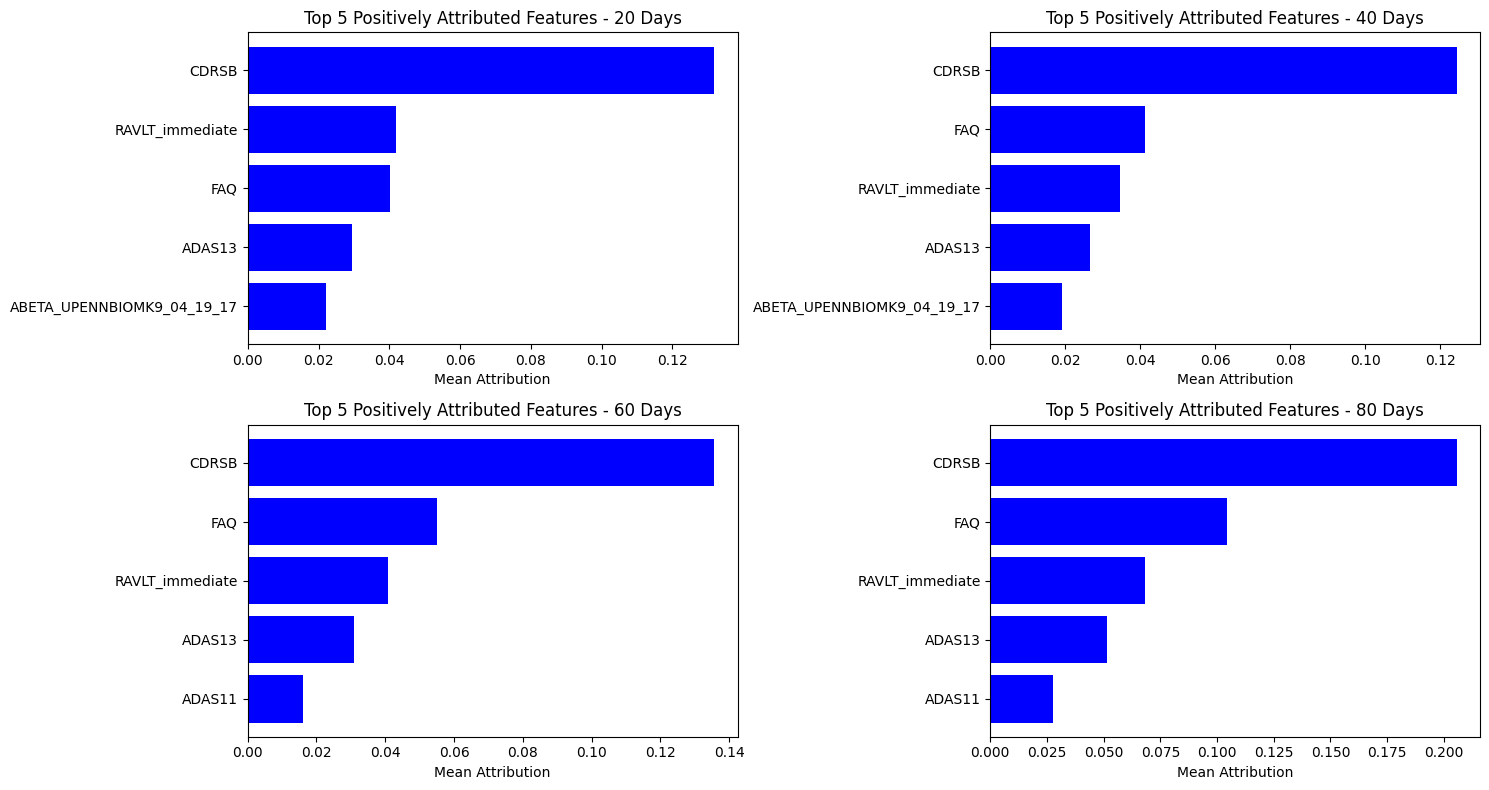

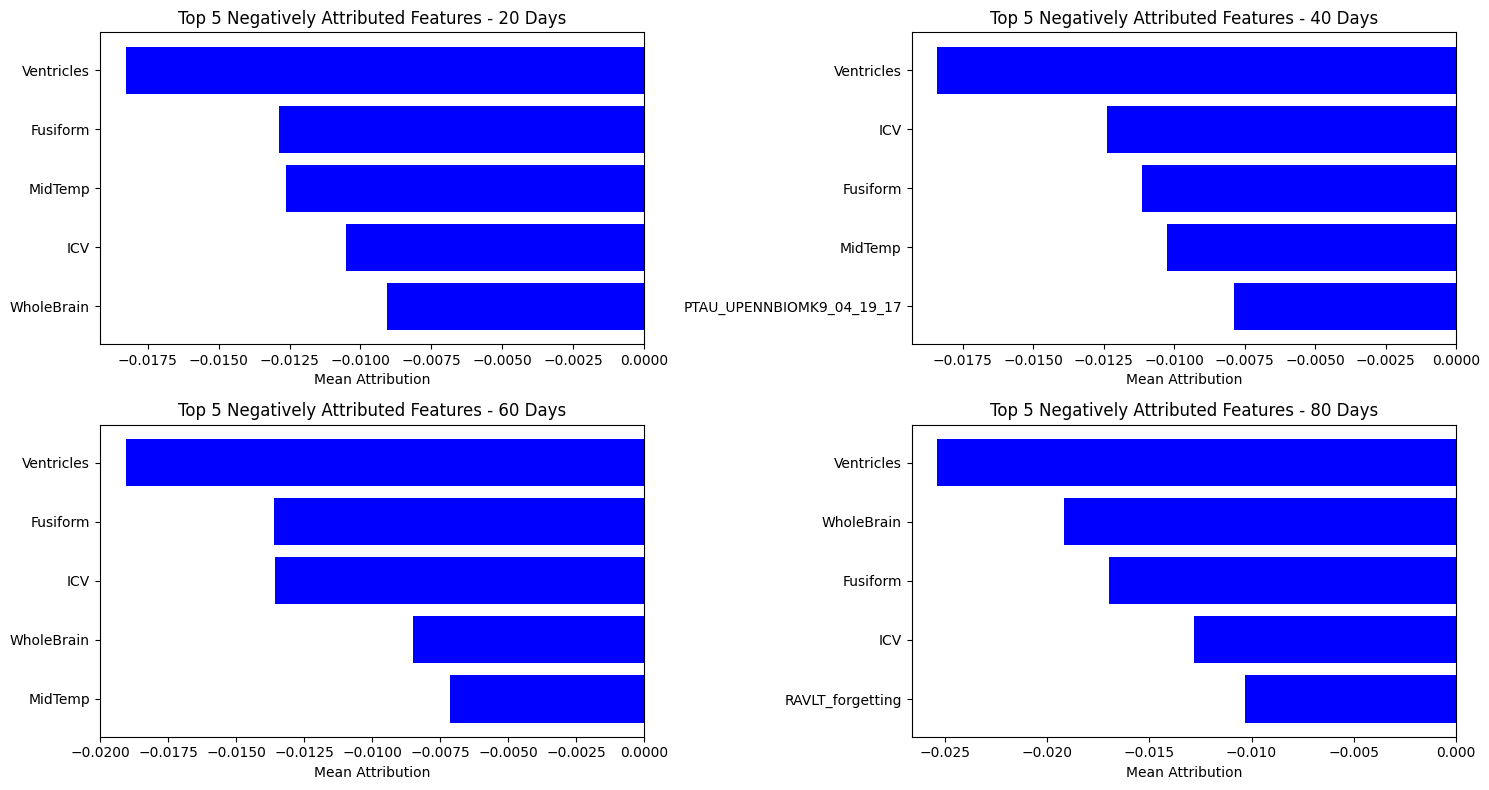

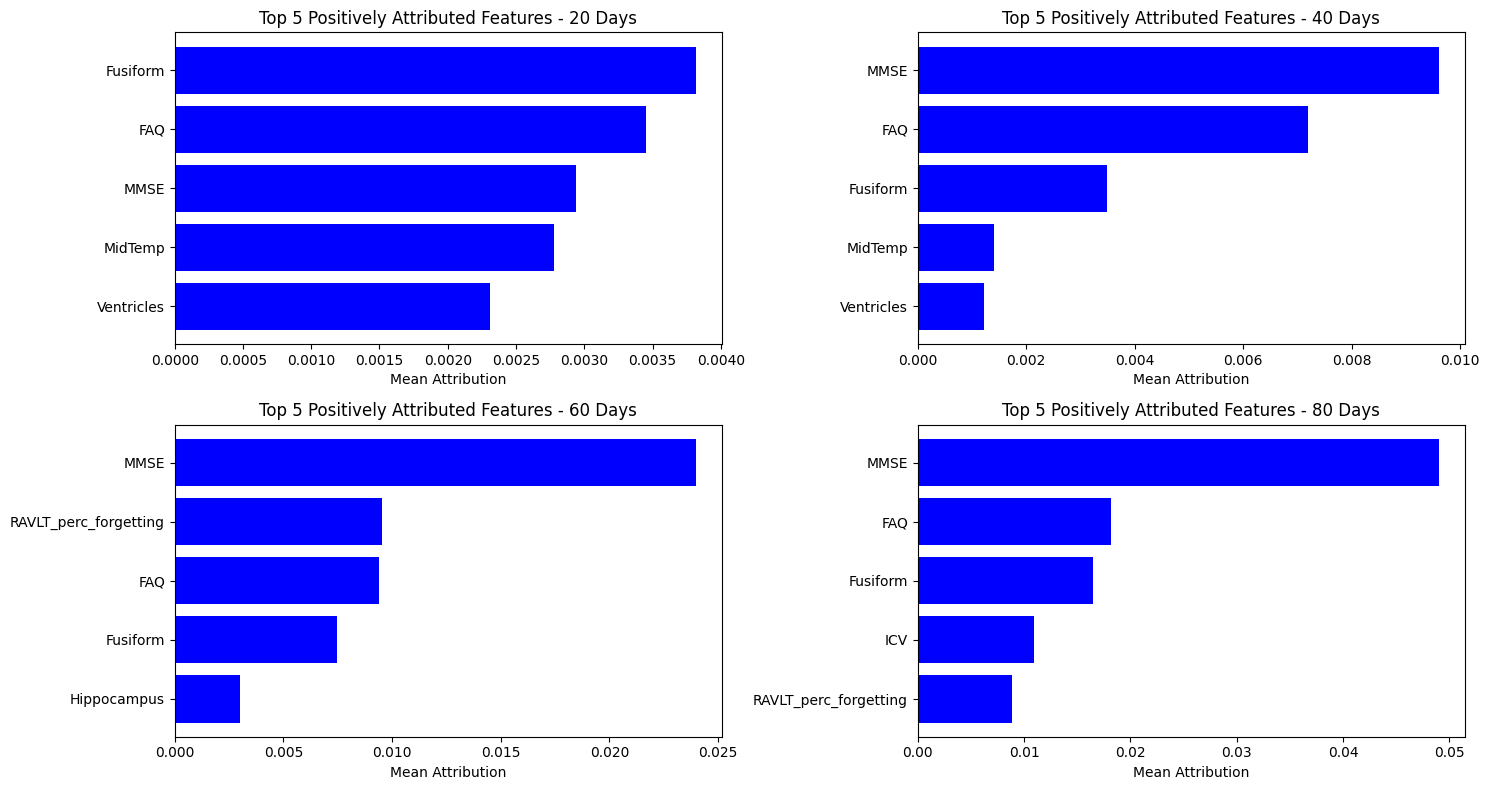

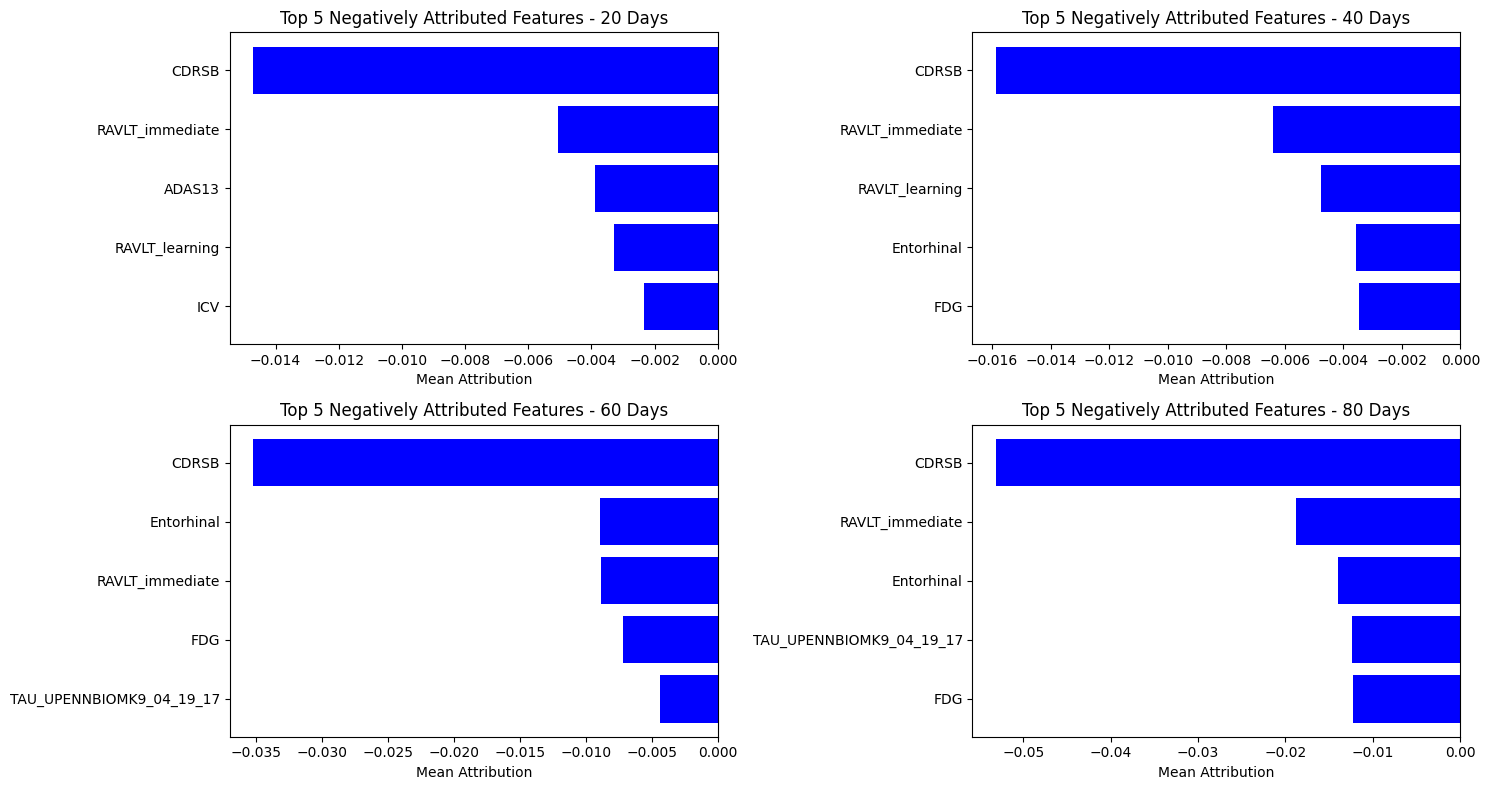

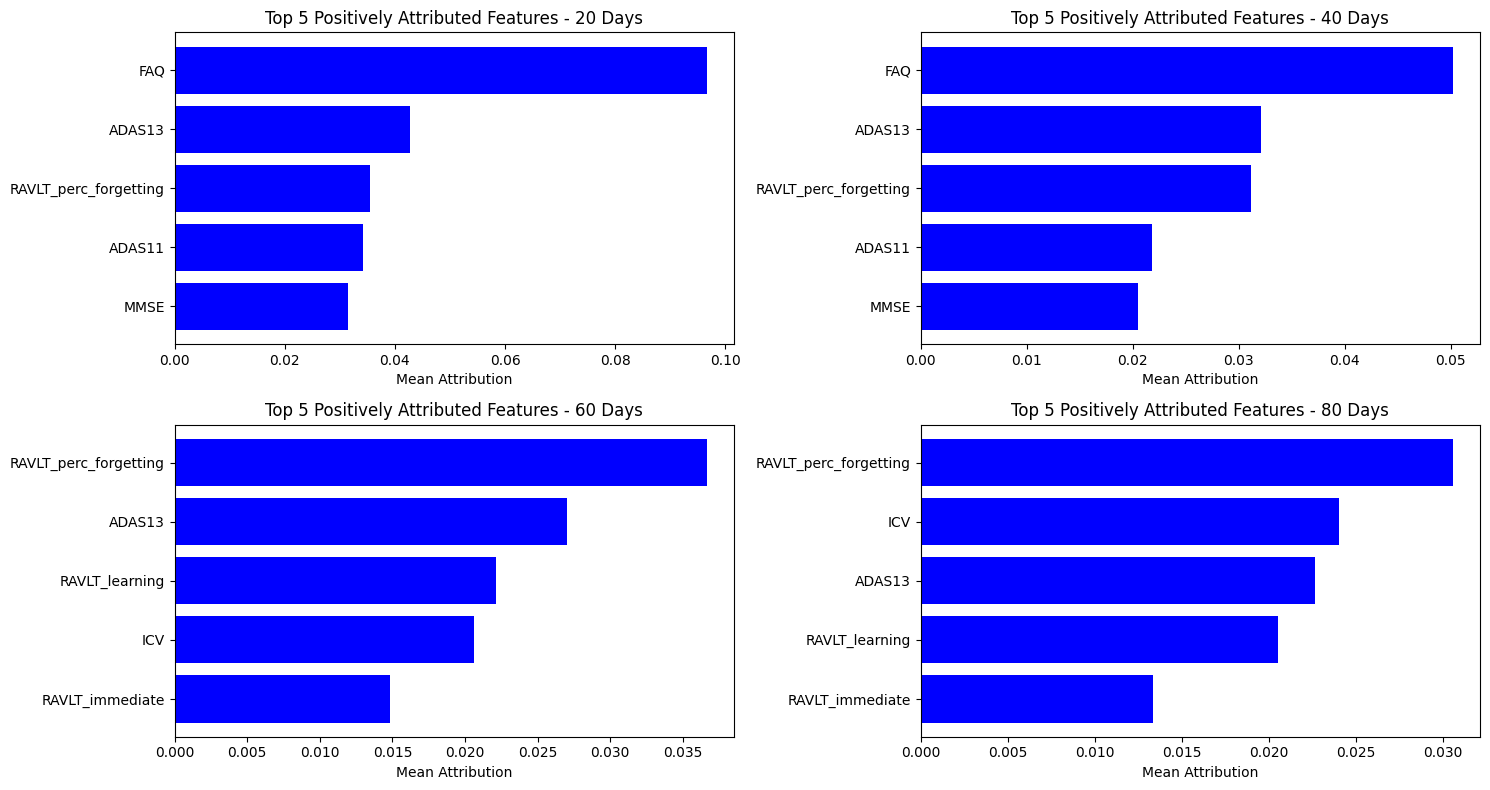

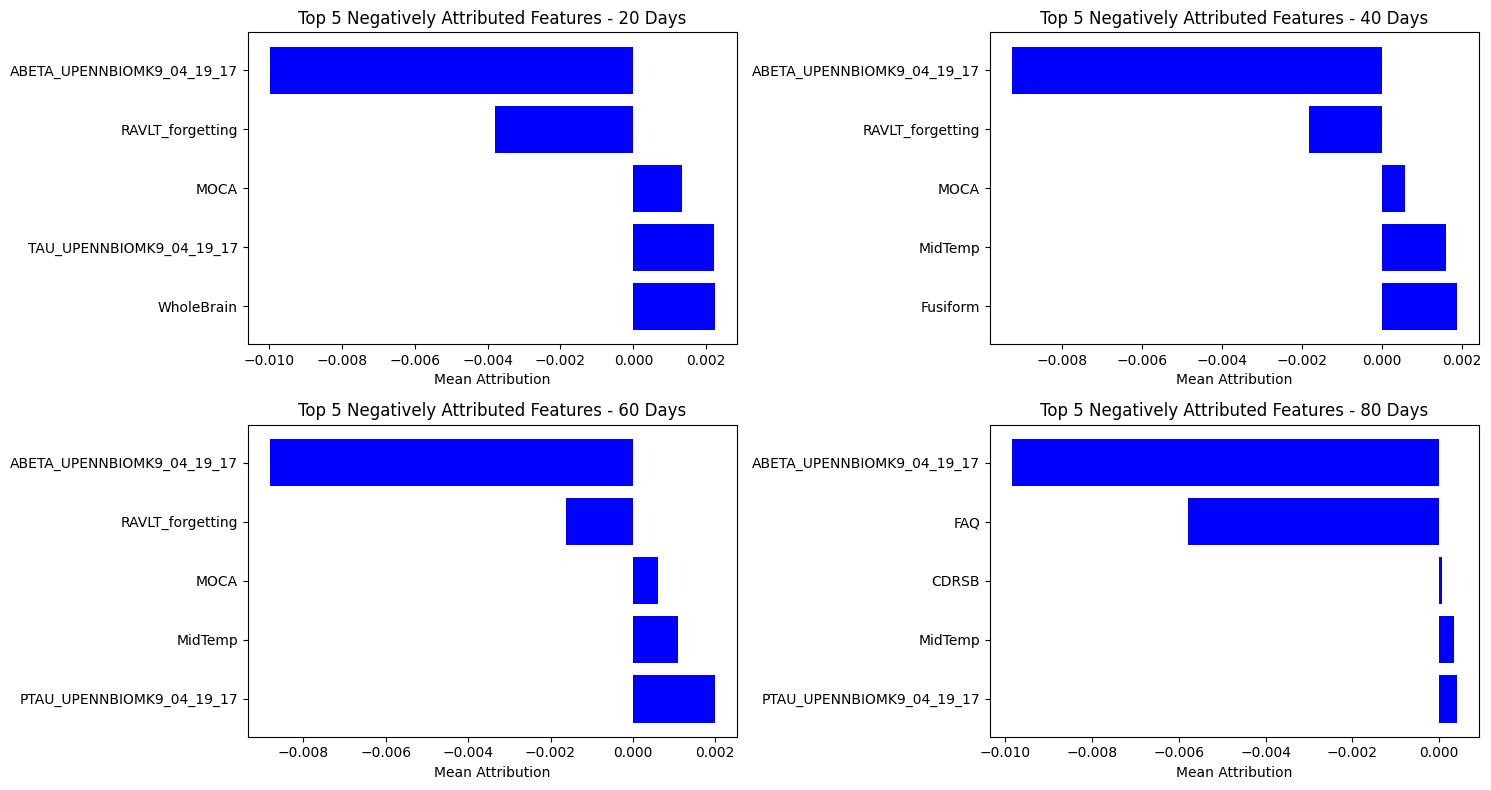

In [117]:
for i in range (0,3):
    plot_features_all_durations(i, 'top')
    plot_features_all_durations(i, 'bottom')

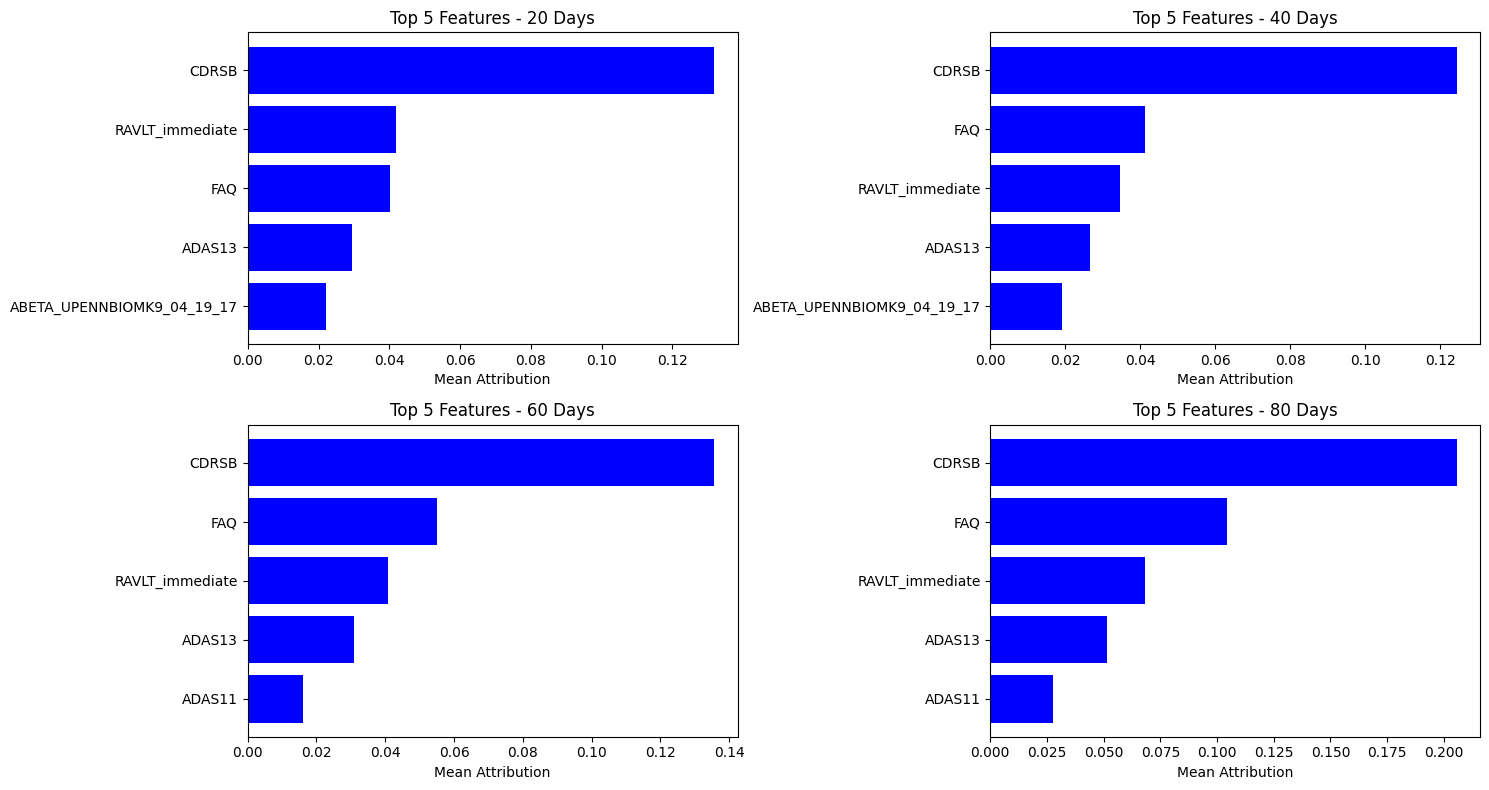

In [109]:
plot_features_all_durations(0, 'top')

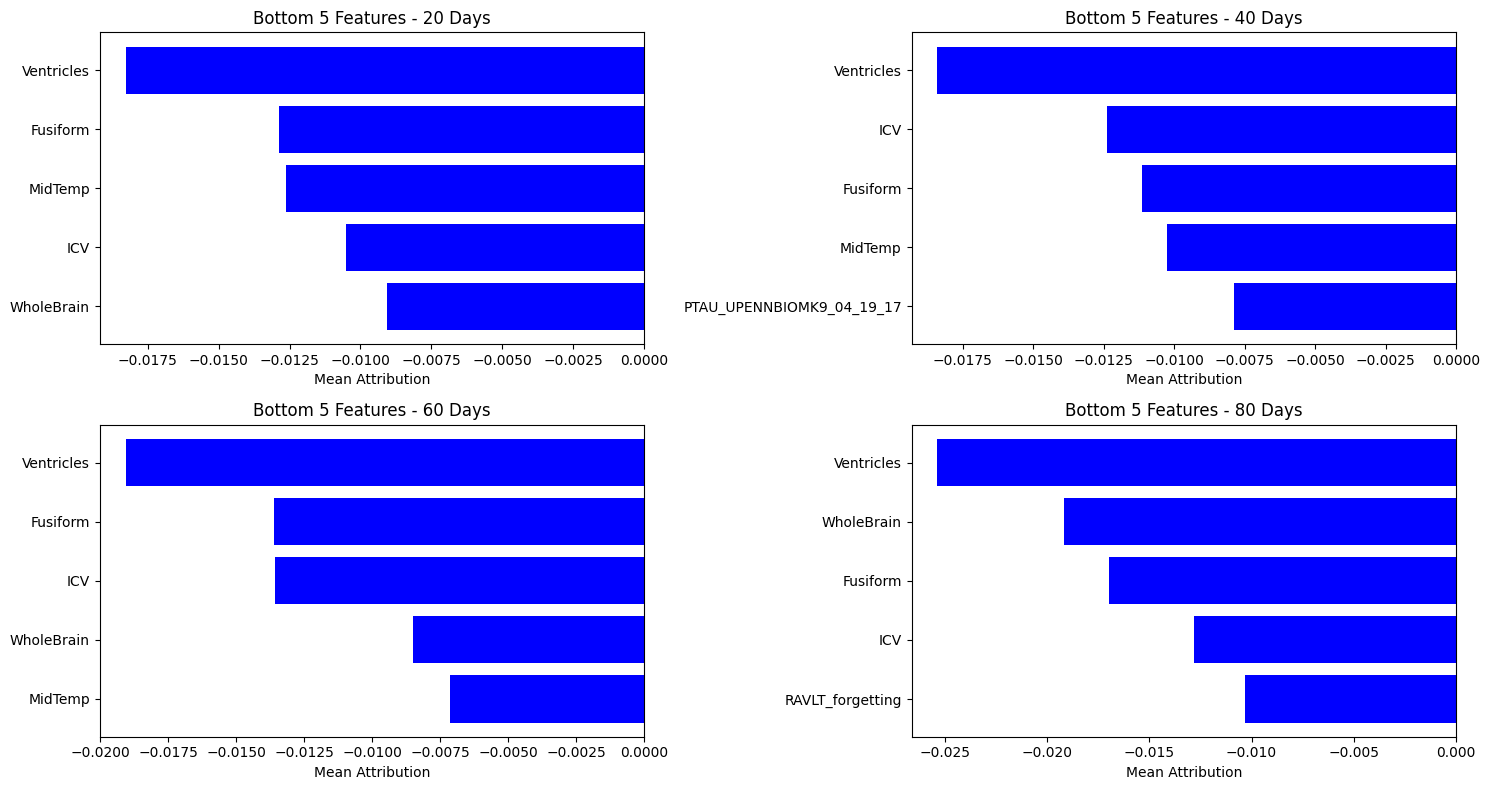

In [110]:
plot_features_all_durations(0, 'bottom')

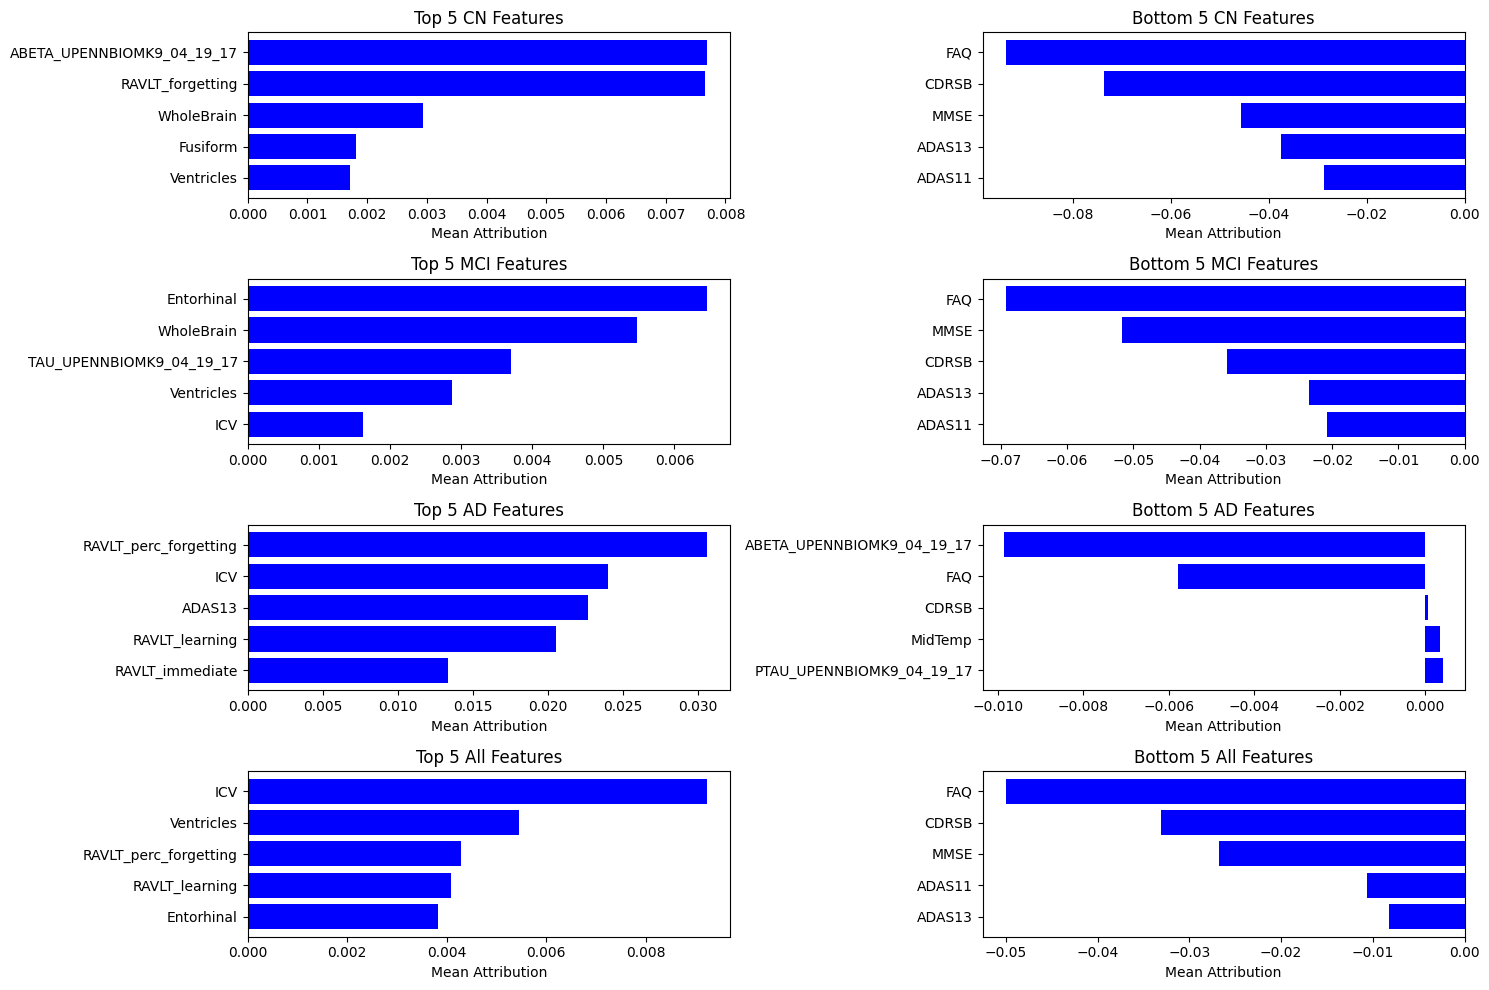

In [28]:
#example usage

plot_top_bottom_features(80, 2)




In [9]:
# sort by specific column values

target_column = 'CN Mean'
df = df.sort_values(by=[target_column], ascending=False)
df

,Feature Name,CN Mean,CN Std,MCI Mean,MCI Std,AD Mean,AD Std,Combined Mean,Combined Std
0,CDRSB,0.131804,0.041333,0.017626,0.025774,-0.003607,0.004603,0.051379,0.065907
4,RAVLT_immediate,0.042023,0.042929,0.004243,0.011008,-0.003346,0.002147,0.015259,0.032759
9,FAQ,0.040125,0.010222,0.007263,0.008526,-0.003174,0.003358,0.015808,0.019927
2,ADAS13,0.029426,0.015279,0.004071,0.006515,-0.002010,0.001361,0.011197,0.016708
19,ABETA_UPENNBIOMK9_04_19_17,0.022144,0.039784,0.001115,0.011409,-0.001111,0.000905,0.007787,0.026598
1,ADAS11,0.018178,0.009388,0.002916,0.004333,-0.001261,0.001119,0.007066,0.010301
5,RAVLT_learning,0.011143,0.025196,0.002166,0.005394,-0.001476,0.001363,0.004286,0.016069
8,MOCA,0.009508,0.012663,0.001014,0.002436,-0.000207,0.000529,0.003622,0.008739
10,Entorhinal,0.007587,0.010120,0.001696,0.005529,-0.000813,0.000955,0.003055,0.007698
18,FDG,0.007284,0.010910,0.001909,0.004481,-0.000540,0.000780,0.003106,0.007696


In [146]:
df = df.sort_values(by=[target_column], ascending=True)
df

,Feature Name,CN Mean,CN Std,MCI Mean,MCI Std,AD Mean,AD Std,Combined Mean,Combined Std
9,FAQ,NaN,NaN,0.052298,0.063847,-0.070392,0.131400,0.016031,0.105402
2,ADAS13,NaN,NaN,0.010744,0.023819,-0.056371,0.054758,-0.009095,0.047158
0,CDRSB,NaN,NaN,0.034485,0.056518,-0.043007,0.083111,0.011578,0.074446
1,ADAS11,NaN,NaN,0.010079,0.014872,-0.029103,0.039646,-0.001503,0.030661
4,RAVLT_immediate,NaN,NaN,-0.001576,0.015098,-0.025331,0.026226,-0.008597,0.021941
7,RAVLT_perc_forgetting,NaN,NaN,-0.003381,0.022189,-0.024871,0.035294,-0.009733,0.028481
3,MMSE,NaN,NaN,0.026167,0.044368,-0.023246,0.067566,0.011561,0.056960
5,RAVLT_learning,NaN,NaN,-0.001524,0.013668,-0.018586,0.024872,-0.006568,0.019367
10,Entorhinal,NaN,NaN,0.000962,0.018497,-0.015247,0.022933,-0.003829,0.021240
13,ICV,NaN,NaN,-0.003125,0.015223,-0.012046,0.029644,-0.005762,0.020966
